## TP QUESTION 1
### Ce notebook s'exécute normalement en moins de 2 minutes. 

In [49]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats 

In [50]:
np.random.seed(123)

In [51]:
# definition of parameters
sigma = 0.6
r = .03
K = 100  
S_0 = 100
T = 1


# other parameters used in the question
mean = 0
std = 1  # std of normal distribution 
sample_size = 50000

### Q1 - Pour différentes valeurs de T, tracer le prix du call européen de maturité T obtenu par la formule de Black & Scholes en fonction de $S_0$ 

$$ \phi(X_i) = e^{-rT}(S_0e^{(r - \frac{\sigma^{2}}{2})T + \sigma X_i \sqrt{T}} - K)_+ $$ 

Notre estimateur du prix:
$$ C_n = \frac{1}{n} \sum_{i=1}^{n}\phi(X_i) $$ 

In [52]:
# q1 parameters

# collection of T to experiments
T_values = {"1 semaine": 5/252, 
            "3 mois": 1/4, 
            "6 mois": 1/2,
            "9 mois": 3/4, 
            "1 an": 1}

# collection of S_0 to experiments
s_0 = np.linspace(0, 1.5*K, 100)

In [53]:
# definition of phi 

def phi(x, s_0, T, sigma=sigma, r=r, K=K):
    """
    phi function used to compute european call price for several 
    x values in the same time. 

    :params x: np.array
        variable of phi function
    :params s_0: float
        Asset value at t=0
    :params T: float
        Maturity 
    :params sigma: float
        volatility
    :params r: float
        ###
    :params K: float
        Strike
    """
    # compute value in exponential
    x_ = (r - (sigma ** 2)/2) * T + sigma * x * np.sqrt(T)
    e_x_ = s_0 * np.exp(x_)

    # compute vector of strike 
    K_ = K + np.zeros_like(x)
    
    return np.exp(-r*T) * np.maximum(e_x_ - K_, np.zeros_like(x))

    

In [54]:
# generate normal distributed samples
samples = np.random.normal(loc=mean, scale=std, size=sample_size)

# final plots
plots = {t: np.zeros(len(s_0)) for t in T_values.keys()}

# compute values
for key, t in T_values.items():
    for i, s in enumerate(s_0):
        # compute phi for each sample
        plots[key][i] = np.mean(phi(samples, s, t))

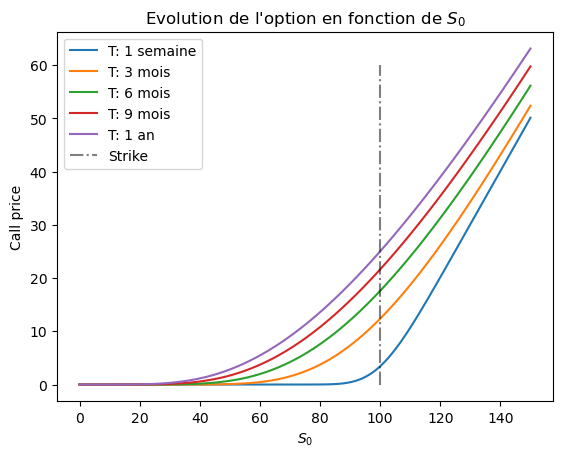

In [55]:
# plot of price for several maturities
for key in T_values.keys():
    plt.plot(s_0, plots[key], label=f"T: {key}")

# add strike on the plot
plt.vlines(x=K, ymin=0., ymax=60., color="black",
           label="Strike", linestyles="dashdot", alpha=.5)

# add legend
plt.title("Evolution de l'option en fonction de $S_0$")
plt.legend()
plt.xlabel("$S_0$")
plt.ylabel("Call price")
plt.show()

### Question 2 - Illustrer la convergence de l'estimateur de Monte Carlo

Nous allons procéder en trois temps: 

1) Calculer à l'instant t=0, quel est le prix exact de l'option que nous cherchons à estimer.
2) Calculer à l'itération n (pour n samples) la valeur estimée par notre estimateur
3) Calculer les intervalles de confiance à l'itération n 

Pour calculer l'estimation nous irons dans cette question jusqu'à:

In [56]:
sample_size_max = 7  # i.e. sample_size == 10**sample_size_max

1. Calculer à l'instant t=0, le prix de l'option grâce à la solution analytique du modèle de Black-Scholes:

$$ S_0 \phi(d_1) - Ke^{-rT}\phi(d_2) $$
avec $\phi$ la fonction de partition de la loi normale centrée réduite et,
$$ d_1 = \frac{ln(\frac{S_0}{K}) + (r+\frac{\sigma^2}{2})T}{\sigma \sqrt{T}} $$ 
$$ d_2 = d_1 - \sigma \sqrt{T} $$ 

In [57]:
# compute target to approach 
d1 = (np.log(S_0/K) + (r + (sigma**2)/2) * T) / (sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)
target = S_0*stats.norm.cdf(d1, loc=0, scale=1) \
         - K * np.exp(-r*T)*stats.norm.cdf(d2, loc=0, scale=1)  

print(f"Target to reach: {target}")

Target to reach: 24.73969972933427


2. Calculer à l'itération n la valeur estimée par notre estimateur

In [58]:
# define nb samples used to compute estimation
n_values = np.floor(np.logspace(2, sample_size_max, num=300))

In [59]:
# compute estimation and std for every n
estimations = np.zeros_like(n_values)
std_estimations = np.zeros_like(n_values)

for i, n in enumerate(n_values):
    samples = np.random.normal(loc=mean, scale=std, size=int(n))
    phi_samples = phi(samples, S_0, T)
    estimations[i] = np.mean(phi_samples)
    std_estimations[i] = np.std(phi_samples)

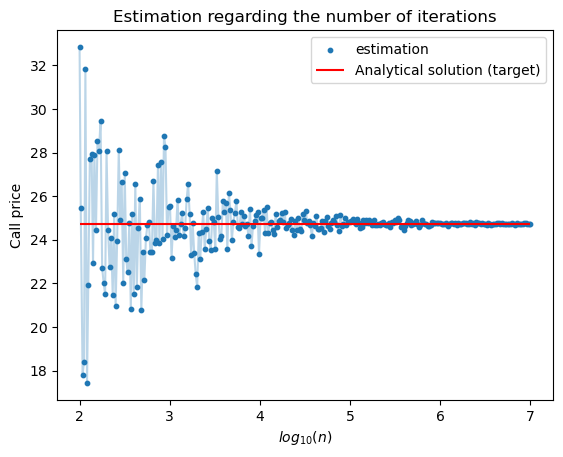

In [60]:
# adapt x-axis to log scale
n_values_log = np.log10(n_values)


# plot esimtations
plt.scatter(n_values_log, estimations, s=10, label="estimation")
plt.plot(n_values_log, estimations, alpha=0.3)

# plot target
plt.hlines(y=target, xmin=2,xmax=sample_size_max, color="red", label="Analytical solution (target)")

# add legend and title
plt.title("Estimation regarding the number of iterations")
plt.xlabel("$log_{10}(n)$")
plt.ylabel("Call price")
plt.legend()
plt.show()

3) Maintenant, nous cherchons à rajouter les intervalles de confiance à chaque itération n pour les rajouter sur notre figure.
Pour cela, nous connaissons la loi asymptotique du pivot: 
$$ R_n = \sqrt{n} \frac{C_n - C_0}{\hat{\sigma_n}} \sim N(0, 1) $$ 

Ainsi, on peut écrire que:
$$ P(q_{\alpha / 2} < R_n < q_{1 - \alpha / 2} ) \approx 1 - \alpha $$
et donc, 
$$ P(\frac{q_{\alpha / 2}\times \hat{\sigma_n}}{\sqrt{n}} + C_n < C_0 < \frac{q_{1 - \alpha / 2} \times \hat{\sigma_n}}{\sqrt{n}} + C_n ) \approx 1 - \alpha $$ 

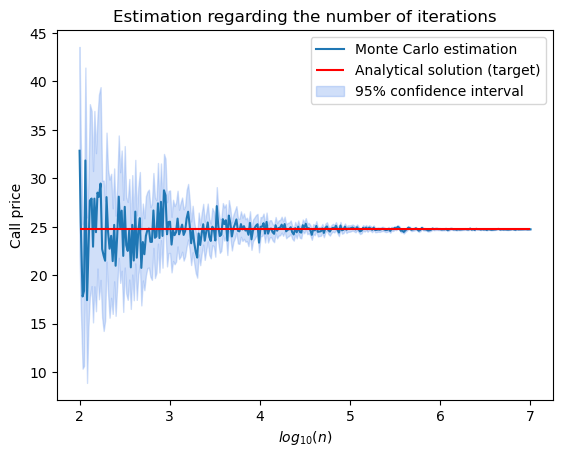

In [61]:
# compute quantiles
alpha=0.05


q = stats.norm.interval(1-alpha, loc=mean, scale=std)[1]

# compute confidence interval
c_i = q*np.divide(std_estimations, np.sqrt(n_values))  # symmetry of normal ditribution

# plot esimtations
plt.plot(n_values_log, estimations, alpha=1, label="Monte Carlo estimation")

# plot target
plt.hlines(y=target, xmin=2, xmax=sample_size_max, color="red", label="Analytical solution (target)")

# plot confidence interval
plt.fill_between(n_values_log, (estimations-c_i), (estimations+c_i), 
                 label="95% confidence interval", color="cornflowerblue", alpha=0.3)

# add legend and title
plt.title("Estimation regarding the number of iterations")
plt.xlabel("$log_{10}(n)$")
plt.ylabel("Call price")
plt.legend()
plt.show()


### Question 3 - Illustrer la vitesse de convergence de l'estimateur

On suppose dans cette question que la vitesse de convergence est en $ \mathcal{O}(n^{-\alpha}) $. Ainsi, dans ce cas, si $ \epsilon $ dénote l'erreur on a:

$$ \epsilon = \mathcal{O}(n^{-\alpha}) \iff log(\epsilon) \sim - \alpha \times log(n) $$

Ainsi, on veut tracer $ log(\epsilon) $ en fonction de $ - log(n) $. En effectuant une regréssion linéaire, nous pouvons mesurer la pente qui nous donnera la valeur de $\alpha$.

Notons tout de même, avec le théorème Centrale-limite, on peut s'attendre à observer $\alpha \geq 0.5 $. 

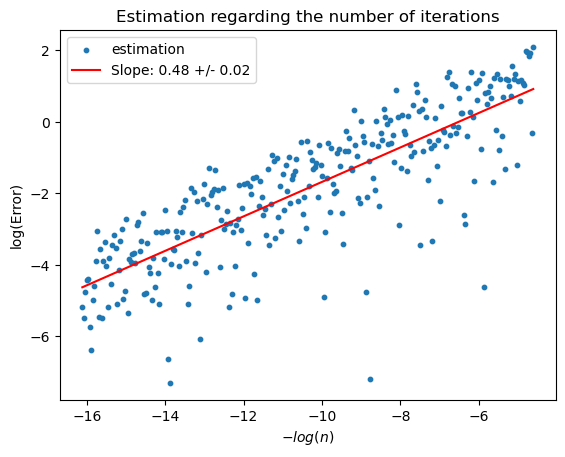

In [62]:
# adapt n and errors to log scale
n_values_log = -np.log(n_values)
errors_log = np.log(np.abs(estimations - target))

# linear regression
reg = stats.linregress(n_values_log, errors_log)
slope = reg.slope
std_slope = reg.stderr

# plot esimtations
plt.scatter(n_values_log, errors_log, s=10, label="estimation")
plt.plot(n_values_log, reg.slope * n_values_log + reg.intercept,
         label=f"Slope: {round(slope, 2)} +/- {round(std_slope, 2)}", color="red")

# add legend and title
plt.title("Error regarding the number of iterations")
plt.xlabel("$-log(n)$")
plt.ylabel("log(Error)")
plt.legend()
plt.show()

Ainsi, on peut concluure que $C_n$ converge environ en $\mathcal{O}(n^{0.5})$ vers la valeur $C_0$.
Notons que nous nous attendions à trouver $0.5$, on peut conclure que notre estimation est cohérente. 

### Question 4 - Illustrer la normalité asymptotique de l'estimateur de Monte-Carlo

Pour évaluer comment se distribue les réalisation de $C_n$, nous allons tirer plusieurs fois des éhantillons de même taille et calculer pour chacun des échantillons une estimation. Pour cela, nous définissons les paramètres suivants:

In [63]:
# nb of samples
nb_estimations = 2000  # nb of estimations to make
nb_samples_per_estimation = 10**5  # size of the sample to compute each estimation

Ainsi, avec cette méthode, nous allons pouvoir tracer une distribution empirique (un histogramme) de notre estimateur $C_n$ pour $n=nb_{estimations}$. Avec le théorème centrale-limite, nous nous attendons à observer une gaussienne. 
En effet, d'après le théorème Centrale-limite $C_n$ converge en loi vers un loi normale.

Réalisons cette expérience

In [64]:
estimations = np.zeros(nb_estimations)

for i in range(nb_estimations):
    samples = np.random.normal(loc=mean, scale=std, size=nb_samples_per_estimation)
    estimations[i] = np.mean(phi(samples, S_0, T))

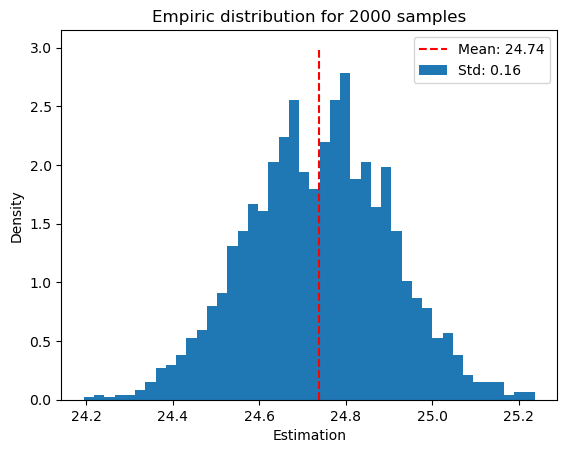

In [65]:
# ditribution of bootstrap samples
nb_bins = int(np.floor(np.sqrt(nb_estimations)))  # rule of thumb for nb of bins
plt.hist(estimations, bins=nb_bins, density=True)

# add the mean
plt.vlines(x=np.mean(estimations), ymin=0, ymax=3, 
           linestyles="dashed", color='red', 
           label="Mean: round(np.mean(estimations), 2)")

# add legend
plt.title(f"Empiric distribution for {nb_estimations} samples")
plt.xlabel('Estimation')
plt.ylabel('Density')
plt.legend([f"Mean: {round(np.mean(estimations), 2)}", f"Std: {round(np.std(estimations), 2)}"])
plt.show()

L'histogramme nous donnes donc une estimations de la denisté de la vairable aléatoire $C_n$. On peut donc voir que comme il est attendu dans le théorème centrale-limite, $C_n$ s'identifie à une loi normale.